In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as cls
import numpy as np
import pandas as pd
import math
import timeit
from scipy.special import logsumexp
from scipy.stats.kde import gaussian_kde

start = timeit.default_timer()
np.random.seed(1)
num = 1000  #particles number
n = np.array(range(num))
t_ = 300000  #timesteps number
t = np.array(range(t_))
zm_3d = np.zeros((t_,num,2), dtype=np.float32)
v_, vmin, a, q, h, lambda_m, lambda_p = 0.2, 0.1, -0.4, 5/3, 0.01, 0.01*215, 0.1*215
l1 = lambda_m*(10.75/215.)**0.5 * (v_/vmin)**(2*a) #for analytical substitiute with lambda_m  
dt = 0.01*l1/v_  #timestep
v = v_ #np.random.normal(loc=v_, scale=v_/5., size=num) #for reference 15keV is approx 0.1 R/s
D_zz = 0.0853*7*lambda_p*v_/54

def n_zt(z, t):
    #analytical formula for density 
    return np.exp(-(z-10.75-v_*t/2)**2 / (4*D_zz*t)) / np.sqrt(4*np.pi*D_zz*t)


In [2]:

def l_1(m):
    #returns different lambdas for the cases where m>0 and m<=0
    
    true_pos = m>0
    true_neg = m<=0

    mu_pos = true_pos*lambda_p
    mu_neg = true_neg*lambda_m

    l_1 = mu_pos + mu_neg
    return l_1

def mu_correction(m):
    #limit mu between 1 and -1
    
    true_more_one = m>1
    true_less_one = m<-1
    true_inrange= ~(true_more_one+true_less_one)

    mu_pos = true_more_one*(1 - m%1)
    mu_neg = true_less_one*(-(m%1))
    mu_zero = true_inrange*m

    m_1 = mu_pos + mu_neg + mu_zero
    return m_1

def constrainM(m):
    #dictate the evolution of mu
    
    zed = np.random.normal(loc=0.0, scale=1.0, size=num)
    l_ = l_1(m)
    l = l_*(zm[:,1]/215)**0.5 * (v/vmin)**(2*a)
    L = 0.5*zm[:,1]
    #for analytical substitute l with l_ and multiply focusing term by zero
    D = (27/14)*v*(1-m**2)*(np.abs(m)**(2/3) + h)/l
    dDdm = 3*v*((1-m**2)*((2/3)*np.sign(m)*np.abs(m)**(-1/3)) - 2.*m*(np.abs(m)**(2/3) + h))/(2*l*(7/9))
    m = m + (dDdm + v*(1-m**2)/(2*L))*dt + np.sqrt(2*D*dt)*zed
    m = mu_correction(m)
    return m

    
def constrainZ(z):
    #dictate the evolution of z
    
    if np.any(z < 1):
        z = 0.9 #the ones that go below 0.05 stick below 0.05  
    else:
        z = z + zm[:,0]*v*dt
    return z

#create a 2D array at each timestep

m, z=0.95, 10.75
zm = np.ones((num, 2))
zm[:,0]=m
zm[:,1]=z

for i in t :
    #evolve mu and z at each timestep
    
    zm[:,0], zm[:,1] = constrainM(zm[:,0]), constrainZ(zm[:,1])
    
    zm_3d[i, :, :] = zm  #3d array made of of 2d arrays for each timestep

    

#print(zm_3d)

Text(0.5, 1.0, '$\\alpha$=-0.4,  $\\lambda_+$=0.1 AU,  $\\lambda_-$=0.01 AU,  v=0.2 [$R_s$/s]')

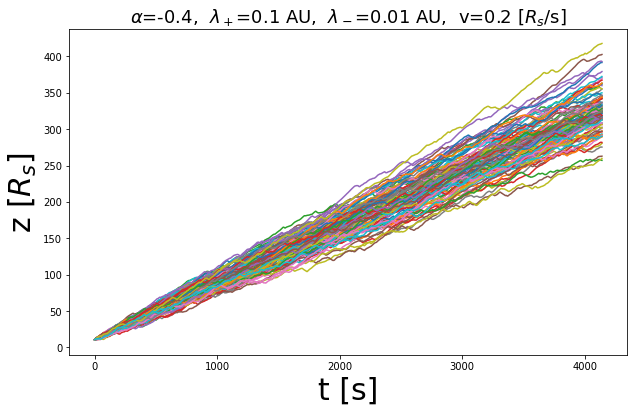

In [3]:
pl = 10*np.array(range(int(num/10)))

#plot z as a function of t for a fraction of the particles
plt.figure(figsize=(10,6))
for j in pl:
    plt.plot(t*dt, zm_3d[:, j, 1])

plt.xlabel('t [s]', fontsize = 30)
plt.ylabel('z [$R_s$]', fontsize = 30)
plt.title(r'$\alpha$='+str(a)+',  $\lambda_+$=' +str(lambda_p/215)+ ' AU,  $\lambda_-$='+str(lambda_m/215)+' AU,  v='+str(v_)+' [$R_s$/s]', fontsize = 18)
#plt.savefig("MCsimZvsT_opt", bbox_inches='tight')

In [4]:
#Turn into columns of a directory and use pandas to analyse them
z_arr_s, m_arr_s=[], []
data={}


for j in n:
    z_arr, m_arr = zm_3d[:, j, 1], zm_3d[:, j, 0]  
    #turn 3d array into 2d array with rows = z/mu at different times, columns = particles
    #insert them into a dataframe
    z_arr_s.append(z_arr)
    m_arr_s.append(m_arr)
    data.update({'particle'+str(j):z_arr})
    

df = pd.DataFrame(data)

[2593.97979798]


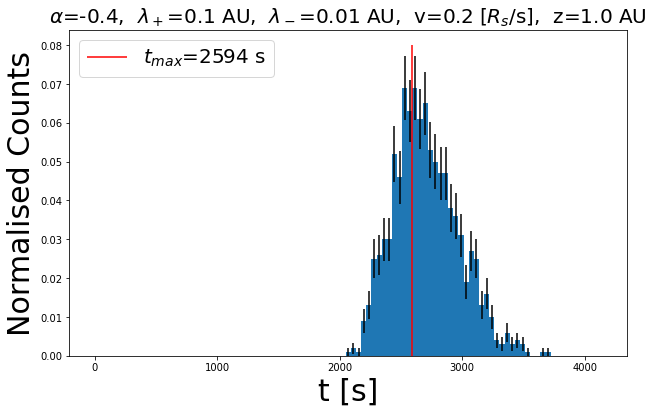

In [5]:

A_z_arr, A_t_arr = np.array([]), np.array([])

detect = 215 #position of detection

for j in n:
    #filter the dataframe for particles that went above a certain position
    filt = df['particle'+str(j)] > detect
    A_z = df['particle'+str(j)].loc[filt].to_numpy()
    if len(A_z)>0:  #take into account the case when no particles have been detected yet
        A_t = df['particle'+str(j)].loc[filt].index[0]  #denote the time when the particle crosses the detection position first
        A_z_arr, A_t_arr = np.append(A_z_arr, np.array([A_z[0]]), axis=0), np.append(A_t_arr, dt*np.array([A_t]), axis=0)

plt.figure(figsize=(10,6))
y, binEdges = np.histogram(np.array(A_t_arr), bins=np.linspace(0, math.ceil(t_*dt), 100).tolist(), weights=(1/num)*np.ones_like(np.array(A_t_arr)))
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd = np.sqrt(y/num)
width = math.ceil(t_*dt)/99
plt.bar(bincenters, y, width=width, yerr=menStd)
peak_t = binEdges[np.where(y == y.max())]  #time for peak of distribution
print(peak_t)
plt.vlines([peak_t], 0, 0.08, 'r', label='$t_{max}$='+str(round(float(peak_t)))+' s')
plt.xlabel('t [s]', fontsize = 30)
plt.ylabel('Normalised Counts', fontsize = 30)
plt.title(r'$\alpha$='+str(a)+',  $\lambda_+$=' +str(lambda_p/215)+ ' AU,  $\lambda_-$='+str(lambda_m/215)+' AU,  v='+str(v_)+' [$R_s$/s],  z='+str(round(detect/215, 1))+' AU', fontsize = 20)
plt.legend(loc='upper left',fontsize = 20)
#plt.savefig("MCsimCountvsT_opt", bbox_inches='tight')


Text(0.5, 1.0, '$\\alpha$=-0.4,  $\\lambda_+$=0.1 AU,  $\\lambda_-$=0.01 AU,  v=0.2 [$R_s$/s],  t=2594 [s]')

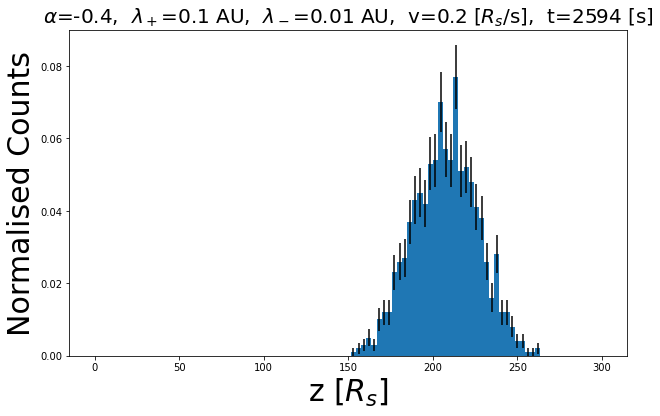

In [6]:
def rghtime(arr, tm):
    '''
    take a 2d array and for each row append 
    the tm-th element of the row to a new array
    '''
    spflux = np.array([])
    for e in arr:
        spflux = np.append(spflux, e[tm])
    return spflux

upp_limz=300
t_ime=int(round(2594/dt, 0))  #time of taking the snapshot
z_solution = np.linspace(0, upp_limz, upp_limz)
plt.figure(figsize=(10,6))
flux_z = np.array(rghtime(z_arr_s, t_ime))  #take position of particles at specific time = t_ime
y, binEdges = np.histogram(flux_z, bins=np.linspace(0, upp_limz, 100).tolist(), weights=(1/num)*np.ones_like(flux_z))
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd = np.sqrt(y/num)  #Poisson normalization
width = upp_limz/99
plt.bar(bincenters, y, width=width, yerr=menStd)
#plt.plot(z_solution, n_zt(z_solution, t_ime*dt), 'r--', label='Analytical Solution')
plt.xlabel('z [$R_s$]', fontsize = 30)
plt.ylabel('Normalised Counts', fontsize = 30)
plt.title(r'$\alpha$='+str(a)+',  $\lambda_+$=' +str(lambda_p/215)+ ' AU,  $\lambda_-$='+str(lambda_m/215)+' AU,  v='+str(v_)+' [$R_s$/s],  t=' + str(round(t_ime*dt)) + ' [s]', fontsize = 20)
#plt.legend(loc='upper left',fontsize = 20)
#plt.savefig("MCsimCountvsZ_opt", bbox_inches='tight')

Time:  231.8277342


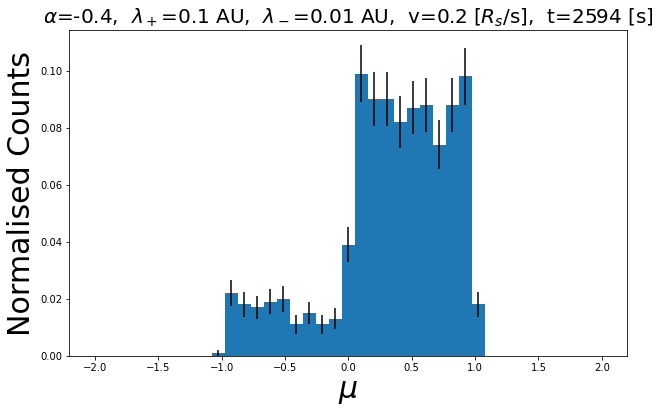

In [7]:
#t_ime=int(round(2594/dt, 0))

plt.figure(figsize=(10,6))
m_count = np.array(rghtime(m_arr_s, t_ime))  #take mu of particles at specific time = t_ime
y, binEdges = np.histogram(m_count, bins=np.linspace(-2, 2, 40).tolist(), weights=(1/num)*np.ones_like(m_count))
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd = np.sqrt(y/num)  #Poisson normalization
width = 0.105
plt.bar(bincenters, y, width=width, yerr=menStd)
plt.xlabel('$\mu$', fontsize = 30)
plt.ylabel('Normalised Counts', fontsize = 30)
plt.title(r'$\alpha$='+str(a)+',  $\lambda_+$=' +str(lambda_p/215)+ ' AU,  $\lambda_-$='+str(lambda_m/215)+' AU,  v='+str(v_)+' [$R_s$/s],  t=' + str(round(t_ime*dt)) + ' [s]', fontsize = 20)
#plt.savefig("MCsimCountvsMt_opt", bbox_inches='tight')

stop = timeit.default_timer()

print('Time: ', stop - start)
        

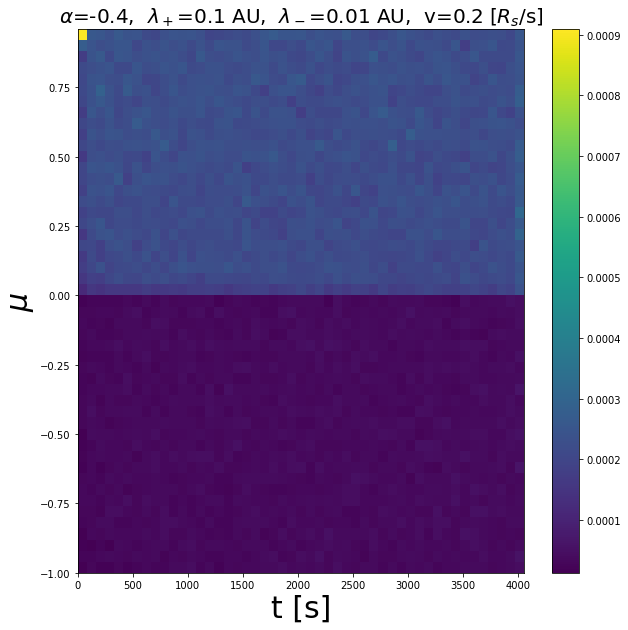

In [8]:
t_alt = 1000
num_alt = 1
f_n = int(num/num_alt)
f_t = int(t_/t_alt)
step = 50
x = (t_/step)*np.array(range(step))*dt
y = 2*np.array(range(step))/step - 1
H = np.array(m_arr_s)[::num_alt, ::t_alt]  #take 2d mu array and only select a fraction of the timesteps
H_new = H.ravel()
talt = t_alt*np.array(range(f_t))*dt
t_matrix = np.ones((f_n, f_t))*talt
t_new = t_matrix.ravel()
#print(H_new)
#print(t_new)
plt.figure(figsize=(10,10))
histo = plt.hist2d(t_new, H_new, bins=[x,y], alpha=1, cmap='viridis', density=True)
plt.colorbar(histo[3])
plt.xlabel('t [s]', fontsize = 30)
plt.ylabel('$\mu$', fontsize = 30)
plt.title(r'$\alpha$=' + str(a) + ',  $\lambda_+$=' + str(lambda_p/215) + ' AU,  $\lambda_-$=' + str(lambda_m/215) + ' AU,  v=' + str(v_) + ' [$R_s$/s]', fontsize = 20)

plt.savefig("MCsimMheatmap_opt", bbox_inches='tight')

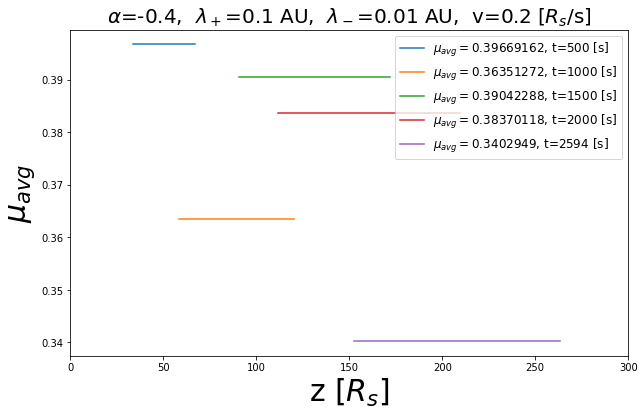

In [14]:
mavg = np.array(m_arr_s).sum(axis=0)/num  #average value of mu for each timestep

def time_round_up(T):
    return int(round(T/dt, 0))

time_k=np.array([500, 1000, 1500, 2000, 2594])  #times you want to plot average mu for

plt.figure(figsize=(10,6))

for k in time_k:
    #below: range of z values at time = t_ime, average value of mu at specific timestep
    z_avg, m_avg = rghtime(z_arr_s, time_round_up(k)), mavg[time_round_up(k)]*np.ones(num)
    zlim, mlim = np.array([np.min(z_avg), np.max(z_avg)]), np.array([mavg[time_round_up(k)], mavg[time_round_up(k)]])
    plt.plot(zlim, mlim, label='$\mu_{avg}=$' + str(mlim[0])  + ', t=' + str(round(time_round_up(k)*dt)) + ' [s]')
    #plt.fill_between(zlim, mlim, alpha=1.)

plt.xlabel('z [$R_s$]', fontsize = 30)
plt.ylabel('$\mu_{avg}$', fontsize = 30)
plt.xlim([0,300])
plt.title(r'$\alpha$='+str(a)+',  $\lambda_+$=' +str(lambda_p/215)+ ' AU,  $\lambda_-$='+str(lambda_m/215)+' AU,  v='+str(v_)+' [$R_s$/s]', fontsize = 20)#,   t=' + str(round(t_ime*dt)) + ' [s]', fontsize = 20)
plt.legend(loc='upper right',fontsize = 12)
#plt.savefig("MCsimMavgvsZ_opt", bbox_inches='tight')